# Self-Driving Car Engineer Nanodegree


## Project 4: **Advanced Lane Finding** 

**The goal of the project is to develop a pipeline for identifying the lane lines and determining the position of the vehicles relative to the lines. 
The input is from images from a front-facing camera mounted at the center of the car.**

## 1. Camera calibration
Using a number of test images of a chessboard, the camera is first calibrated, i.e a distortion and rotation matrice are computed using the OpenCV library.
These distortion correction matrices are then used to undistort each image of the road captured by the camera.
An example of a calibration image of a chessboard is shown here:
    
---

<figure>
 <img src="camera_cal/calibration1.jpg" width=380 alt="Calibration image" />
 </figcaption>
</figure>

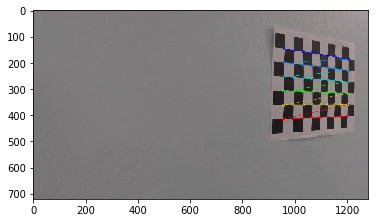

In [3]:
import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# read in and make a list of calibration images filenames
images = glob.glob('./camera_cal/calibration*.jpg')
#print(images)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

for fname in images:
    # Read in an image
    img = cv2.imread(fname)
    plt.imshow(img)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    nx = 9 # the number of chessboard inside corners in x
    ny = 6 # the number of chessboard inside corners in y

    # prepare object points
    # initialize an array of 3D object points to 0.
    objp = np.zeros((ny*nx, 3), np.float32)
    # x,y coordinates
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, append and draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)


def calibrate(img_shape, objpoints, imgpoints):
    # A function that takes an image, object points, and image points
    # performs the camera calibration using cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return [ret, mtx, dist, rvecs, tvecs]

def undistort(img, mtx, dist):
    # A function that performs image distortion correction and
    # returns the undistorted image using cv2.undistort()
    return cv2.undistort(img, mtx, dist, None, mtx)
    


 ### Example of a distortion corrected calibration image.

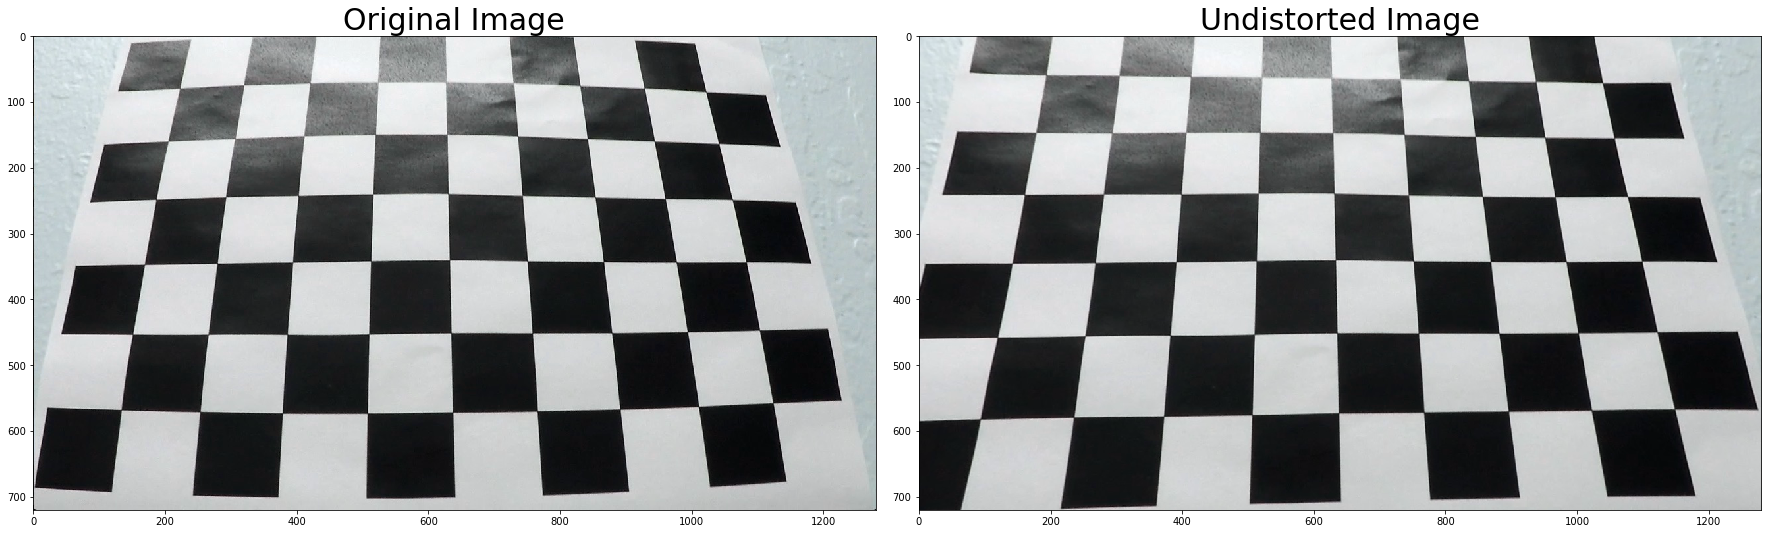

In [4]:
# Read in an image
img = cv2.imread('./camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calibrate based on the pre-computed object and image points
# Using the current image shape:

cal_params = calibrate(img.shape[0:2], objpoints, imgpoints)

# Undistort the image using the calibrated matrices mtx and dist
undistorted = undistort(img, cal_params[1], cal_params[2])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Example undistorted image
road_img = mpimg.imread('./test_images/test2.jpg')
road_img_undist = undistort(road_img, cal_params[1], cal_params[2])
_ = cv2.imwrite('./output_images/undistorted_road.jpg', road_img_undist[:, :, ::-1])

## 2. Line detection pipeline
** A pipeline to find and plot lane lines on an image from a front-facing car camera. **

### Gradient and color thresholds:

In [5]:
def abs_sobel_thresh(scaled_sobel, thresh=(0, 255)):
    '''A function that applies an absolute sobel threshold.
    Parameters:
    scaled_sobel: a scaled gradient
    thresh: a tuple containing the minimum and maxium thresholds
    Returns:
    binary_output: a mask with 1's where the scaled absolute sobel gradient is within
                   the minimum and maximum thresholds
    '''
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    return binary_output
    

def mag_thresh(sobelx, sobely, mag_thresh=(0, 255)):
    '''A function that computes the magnitude of the gradient and applies a threshold.
    Parameters:
    sobelx: a gradient in the direction of x
    sobely: a gradient in the direction of y
    mag_thresh: a tuple containing the minimum and maxium thresholds
    
    Returns:
    binary_output: a mask with 1's where the scaled sobel gradient is within
                   the minimum and maximum thresholds
    '''
    # Calculate the magnitude of the gradient
    sobel_norm = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*sobel_norm / np.max(sobel_norm))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(abs_sobelx, abs_sobely, dir_thresh=(0, np.pi/2)):
    '''A function that calculates the direction of the gradient and applies a threshold.
    Parameters:
    abs_sobelx: absolute value of the gradient in the direction of x
    abs_sobely: absolute value of the gradient in the direction of y
    dir_thresh: a tuple of the minimum and maxium thresholds in radians
    
    Returns:
    binary_output: a mask with 1's where the scaled sobel gradient is within
                   the minimum and maximum thresholds
    '''
    # np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    # Return this mask as your binary_output image
    binary_output[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    return binary_output
    

def color_threshold(img, s_thresh=(0,255)):
    # A function to separate the image in HLS channels and return
    # a binary mask when certain channel is within the min and max thresholds
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) ## 2BGR or 2RGB depending on img
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary


def detection_pipeline(img, cal_params, sobel_kernel=3):
    ''' Parameters:
    img: the input image
    cal_params: a list of parameters, pre-computed by the camera calibration function
                [ret, mtx, dist, rvecs, tvecs]
    
    '''  
    # undistort
    undist = undistort(img, cal_params[1], cal_params[2]) 
    
    #image = mpimg.imread('bridge_shadow.jpg')
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(scaled_sobelx, thresh=(40, 100))
    grady = abs_sobel_thresh(scaled_sobely, thresh=(40, 100))
    mag_binary = mag_thresh(sobelx, sobely, mag_thresh=(50, 120))
    dir_binary = dir_threshold(abs_sobelx, abs_sobely, dir_thresh=(0.7, 1.3))
    
    # combine gradient thresholds
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # S-channel Color threshold
    s_binary = color_threshold(undist, s_thresh=(180, 255))

    # Stack each the gradient and color binary masks
    # color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(s_binary), grad_combined, s_binary))
    
    # Combine the color and gradient binary thresholds
    combined_binary = np.zeros_like(grad_combined)
    combined_binary[(s_binary == 1) | (grad_combined == 1)] = 1
    
    return color_binary, combined_binary


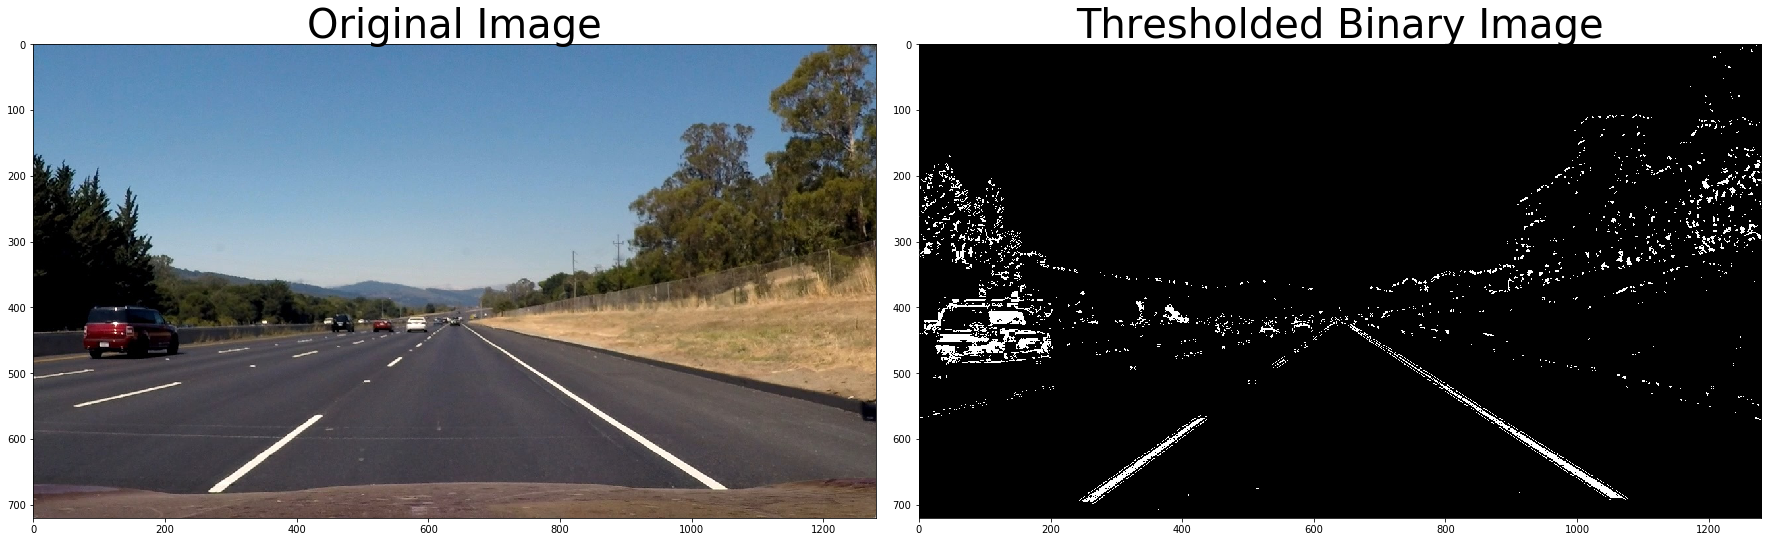

In [6]:
# Visualize output of the color and gradient threshold

image = mpimg.imread('./test_images/straight_lines2.jpg')

# Choose a Sobel kernel size
kernel_size = 7 # Choose a larger odd number to smooth gradient measurements

result = detection_pipeline(image, cal_params, sobel_kernel=kernel_size)[1]

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
result_gray = result * 255.0
_ = cv2.imwrite('./output_images/binary_road.jpg', result_gray)

### Perspective transform:

In [19]:
# warp image to get a perspective transform

def transform_mat(img_size):
#     src = np.float32(
#         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#         [((img_size[0] / 6) - 10), img_size[1]],
#         [(img_size[0] * 5 / 6) + 60, img_size[1]],
#         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dst = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])


#     src = np.float32([(220, 719), (550, 480), (730, 480), (1060, 719)])
#     dst = np.float32([(220, 719), (220, 180), (1060, 180), (1060, 719)])
    # best
    src = np.float32([(200, 720), (580, 480), (720, 480), (1080, 720)])
    dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def img_warp(img, M):
    # A function to transform the perspective into "birds eye view"
    # Parameters: M: a transformation matrix calculated with cv2.getPerspectiveTransform
    
    img_size = (img.shape[1], img.shape[0])   
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

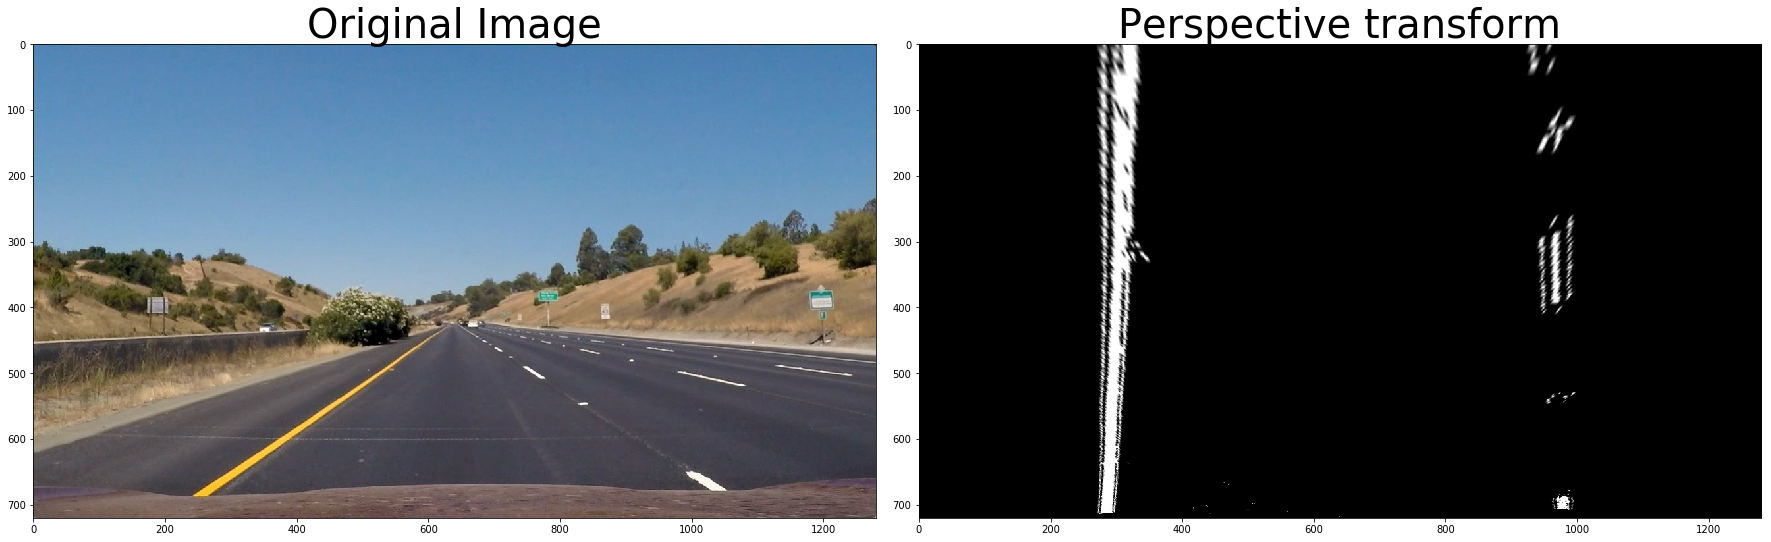

In [21]:
# Visualize output of the perspective transform

image = mpimg.imread('./test_images/straight_lines1.jpg')

# Choose a Sobel kernel size
kernel_size = 5 # Choose a larger odd number to smooth gradient measurements

result = detection_pipeline(image, cal_params, sobel_kernel=kernel_size)[1]
t_map = transform_mat(result.shape[::-1])[0]
result = img_warp(result, t_map)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Perspective transform', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
result_gray_warp = result * 255.0
_ = cv2.imwrite('./output_images/warped_straight_lines.jpg', result_gray_warp)

### Line detection using sliding windows:

In [9]:
def line_detect(img):
    # Parameters:
    # img: a warped binary image with detected line pixels
    binary_warped = img

    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,], axis=0)
    #plt.plot(histogram)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #print(histogram.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### Visualize
    # Generate x and y values for plotting
    
    # Fitted line x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx

In [10]:
def roi(img, left_f, right_f):
    ''' Detect lane with a region of interest from a line detection from previous image
    Parameters:
     img: a binary warped image
     left_fit, right fit: a polynomial fit of the left and right lane lines, 
                            computed from a previous image.
    '''
    binary_warped = img
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_f[0]*(nonzeroy**2) + left_f[1]*nonzeroy + left_f[2] - margin)) & (nonzerox < (left_f[0]*(nonzeroy**2) + left_f[1]*nonzeroy + left_f[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_f[0]*(nonzeroy**2) + right_f[1]*nonzeroy + right_f[2] - margin)) & (nonzerox < (right_f[0]*(nonzeroy**2) + right_f[1]*nonzeroy + right_f[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx

In [11]:
def plot_fitted(binary_warped, left_fitx, right_fitx):
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    plt.imshow(out_img)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

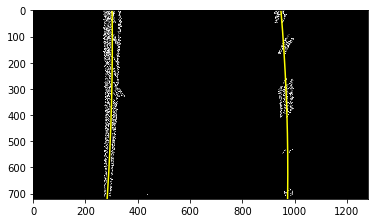

In [22]:
binary_warped = result # binary warped image (B/W)
plot_fitted(binary_warped, *line_detect(binary_warped)[-2:])

In [13]:
## Measuring curvature radius

def curvature(img, left_fit, right_fit, left_x, right_x, left_y, right_y, left_fitx, right_fitx):
    binary_warped = img
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_curverad, right_curverad


In [23]:
line_params = line_detect(result)
curvature(result, *line_params)

(3003.4542734856213, 2376.4135194557857)

In [74]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [] #np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # the curvature of the last successful fit
        self.recent_curv = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
# 'Sanity-checks'
def check_curvature(left_curvature, right_curvature, threshold=2000):
    #print('Curvature check: ', np.abs(right_curvature - left_curvature) < threshold, left_curvature - right_curvature)
    return np.abs(right_curvature - left_curvature) < threshold


def check_separation(left_line, right_line, sep_threshold=150, lane_width=720 , lane_threshold=150):

    # horizontal separation, check if lines are approximately parallel 
    # threshold in pixels
    sep_top = right_line[0] - left_line[0]
    sep_bottom = right_line[-1] - left_line[-1]
    sep = np.abs(sep_top - sep_bottom) < sep_threshold
    #print('Check_separation: top vs bottom', sep_top, sep_bottom)
    
    # check if distance between lines is approximately right distance
    forms_lane = np.abs(sep_top - lane_width) < lane_threshold and np.abs(sep_bottom - lane_width) < lane_threshold
    #print('Forms lane: ', forms_lane)
    return sep and forms_lane

In [72]:
def img_unwarp(orig_img, bin_warped, Minv, left_fit, right_fit, offset=None, side=None, curvature=None): # unwarp and project the lines onto the original image
    
    #print('Left and right fit inside img_unwrap: ', left_fit,right_fit)
    
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    # annotate image with Curvature and vehicle position data
    cv2.putText(result, 'Vehicle is {0:.2f} meters {1:s} of Center'.format(offset, side), (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (256,256,256), thickness=2)
    cv2.putText(result, 'Radius of Curvature: {:.2f} meters'.format(curvature), (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (256,256,256), thickness=2)
    return result

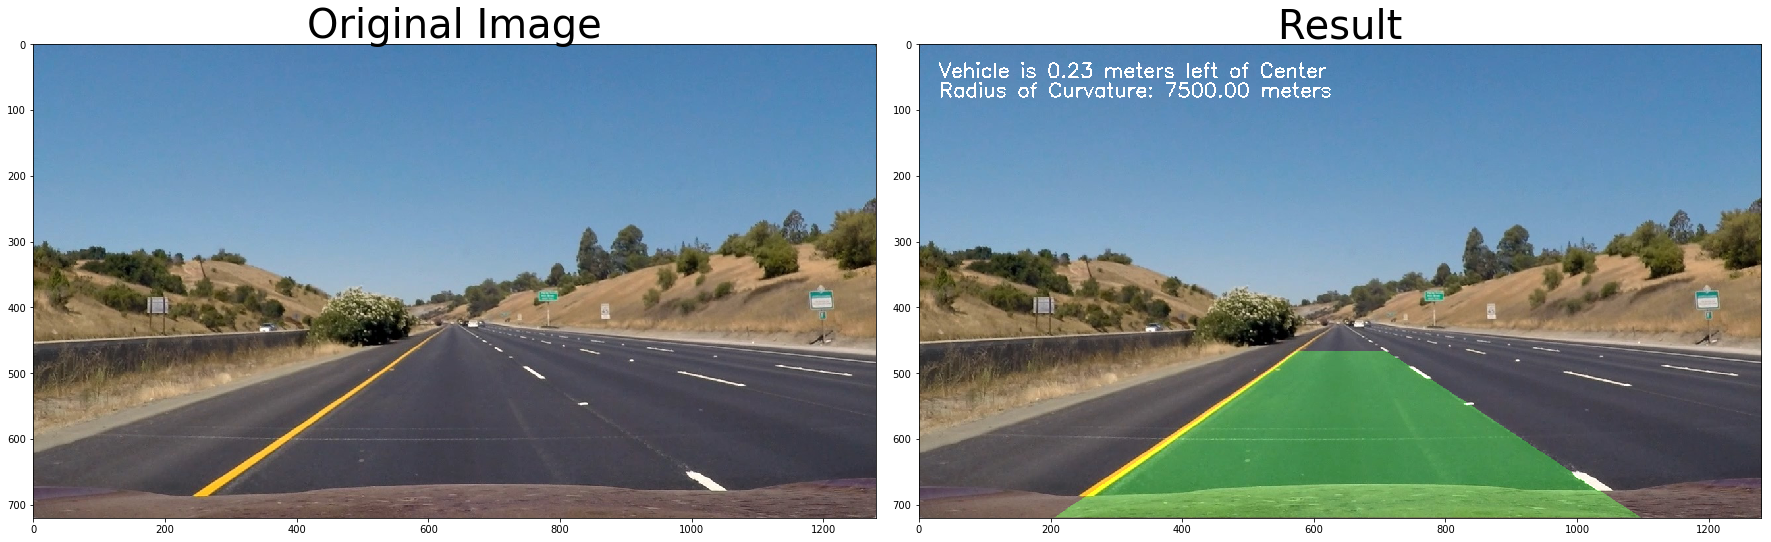

In [82]:
t_invmap = transform_mat((1280, 720))[1]
res = img_unwarp(image, binary_warped, t_invmap, line_params[0], line_params[1], 0.23, "left", 7500)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(res)
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
_ = cv2.imwrite('./output_images/example_output.jpg', res[:, :, ::-1])

In [80]:
# transformation matrices
t_map = transform_mat((1280,720))[0]
t_invmap = transform_mat((1280,720))[1]

left_line = Line()
right_line = Line()
kernel_size = 7
# image processing pipeline 
def process_image(img, cal_params, n_avg = 5):
    result = detection_pipeline(img, cal_params, sobel_kernel=kernel_size)[1]
    warped_binary = img_warp(result, t_map)
    
    if left_line.detected and right_line.detected:
        # use region of interest search
        #print('Before Roi search: ', left_line.current_fit[-1], right_line.current_fit[-1])
        line_params = roi(warped_binary, left_line.current_fit[-1], right_line.current_fit[-1]) 
        #print('AFTER Roi search: ', line_params[0], line_params[1])
        #plot_fitted(warped_binary, *line_params[-2:])
    else:
        # left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx
        line_params = line_detect(warped_binary) 
    
    # get curvature radius for both lines in meters
    left_curve, right_curve = curvature(warped_binary, *line_params)
    if left_line.radius_of_curvature == None:
        left_line.radius_of_curvature = left_curve
    if right_line.radius_of_curvature == None:
        right_line.radius_of_curvature = right_curve

    
    # the position of the camera in the image
    camera_center = binary_warped.shape[1] // 2
    
    # sanity checks: 
    # similar curvature
    # separated by approximately the right distance horizontally
    # roughly parallel

    # "sanity checks"
    if check_separation(*line_params[-2:]) and check_curvature(left_curve, right_curve): # left_line.check_curvature(left_curve) and left_line.check_slope(line_params[0]) and check_separation(line_params[2], line_params[3]):

        #print('LEFT PASS')
              
        # found a fit, update lines parameters
        left_line.detected = True
        
        # left line
        
        # append x values to x values array of the last n fits of the line
        left_line.recent_xfitted.append(line_params[6])
        left_line.current_fit.append(line_params[0])
        left_line.radius_of_curvature = left_curve
        
        left_line.base_pos = camera_center - line_params[6][-1] # [line_params[4]==np.max(line_params[4])]
        left_line.diffs = left_line.current_fit[-1] - line_params[0] # difference in fit coefficients between last and new fits #np.array([0,0,0], dtype='float') 
        left_line.allx = line_params[2] # x values for detected line pixels
        left_line.ally = line_params[4]# y values for detected line pixels
        # print(type(left_line.current_fit))
        ### left_line.current_fit.append(line_params[0])
        # average x values of the fitted line over the last n iterations
        left_line.bestx =  np.mean(left_line.recent_xfitted[-n_avg:], axis=0)    
        # polynomial coefficients averaged over the last n iterations
        #print(left_line.current_fit)
        left_line.best_fit = np.mean(left_line.current_fit[-n_avg:], axis=0)    
    #else:
        #left_line.detected = False
        #print('NO LEFT PASS')
        
        
    #if True: #right_line.check_curvature(right_curve) and right_line.check_slope(line_params[1]) and check_separation(line_params[2], line_params[3]):
        #print('RIGHT PASS')
        # right line 
        right_line.detected = True
        
        # append x values to x values array of the last n fits of the line
        right_line.recent_xfitted.append(line_params[7])
        right_line.current_fit.append(line_params[1])
        right_line.radius_of_curvature = right_curve
        right_line.base_pos = line_params[7][-1] - camera_center #[line_params[5] == np.max(line_params[5])]
        right_line.diffs =  right_line.current_fit[-1] - line_params[1] # difference in fit coefficients between last and new fits
        right_line.allx =  line_params[3]# x values for detected line pixels
        right_line.ally = line_params[5]# y values for detected line pixels
        ###right_line.current_fit.append(line_params[1])
        # average x values of the fitted line over the last n iterations
        right_line.bestx =  np.mean(right_line.recent_xfitted[-n_avg:], axis=0)    
        # polynomial coefficients averaged over the last n iterations
        right_line.best_fit = np.mean(right_line.current_fit[-n_avg:], axis=0)
                
        #print('Left and Right Fit: ', left_line.current_fit, right_line.current_fit)
          
    else:
        # no lines detected in the image, use previous fit
        left_line.detected = False
        right_line.detected = False

        # line_params =  previous fitted parameters
        #print('NO LEFT PASS')
        #print('NO RIGHT PASS')
    
    # arguments to img_unwarp to display radius and distance data on the image
    side = None
    vehicle_offset_px = right_line.bestx[-1] + left_line.bestx[-1] - 2 * camera_center 
    
    if vehicle_offset_px >= 0:
        side = 'Right'
    else: 
        side = 'Left'
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset_m = vehicle_offset_px * xm_per_pix
    # average radius of the 2 curves. To be passed to the img_unwrap() function.
    radius = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
        
   
    if left_line.best_fit == None or right_line.best_fit == None:
        return img
    unwarped = img_unwarp(img, warped_binary, t_invmap, left_line.best_fit, right_line.best_fit, offset=np.abs(vehicle_offset_m), side=side, curvature=radius)

    
    return unwarped


In [42]:
# Video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
vid_output = './output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4") # .subclip(40,50)
white_clip = clip1.fl_image(lambda x : process_image(x, cal_params)) #NOTE: this function expects color images!!
%time (white_clip.write_videofile(vid_output, audio=False))

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/home/kz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:115: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


100%|█████████▉| 1260/1261 [06:43<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

CPU times: user 8min 32s, sys: 20 s, total: 8min 52s
Wall time: 6min 45s


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_clip))